In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/jigsaw-unintended-bias-in-toxicity-classification/sample_submission.csv
/kaggle/input/jigsaw-unintended-bias-in-toxicity-classification/all_data.csv
/kaggle/input/jigsaw-unintended-bias-in-toxicity-classification/test_public_expanded.csv
/kaggle/input/jigsaw-unintended-bias-in-toxicity-classification/test_private_expanded.csv
/kaggle/input/jigsaw-unintended-bias-in-toxicity-classification/toxicity_individual_annotations.csv
/kaggle/input/jigsaw-unintended-bias-in-toxicity-classification/train.csv
/kaggle/input/jigsaw-unintended-bias-in-toxicity-classification/identity_individual_annotations.csv
/kaggle/input/jigsaw-unintended-bias-in-toxicity-classification/test.csv
/kaggle/input/pickled-glove840b300d-for-10sec-loading/glove.840B.300d.pkl


# Data Exploration

In [2]:
train = pd.read_csv("../input/jigsaw-unintended-bias-in-toxicity-classification/train.csv")
test = pd.read_csv("../input/jigsaw-unintended-bias-in-toxicity-classification/test.csv")

In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1804874 entries, 0 to 1804873
Data columns (total 45 columns):
 #   Column                               Dtype  
---  ------                               -----  
 0   id                                   int64  
 1   target                               float64
 2   comment_text                         object 
 3   severe_toxicity                      float64
 4   obscene                              float64
 5   identity_attack                      float64
 6   insult                               float64
 7   threat                               float64
 8   asian                                float64
 9   atheist                              float64
 10  bisexual                             float64
 11  black                                float64
 12  buddhist                             float64
 13  christian                            float64
 14  female                               float64
 15  heterosexual                    

## Text Cleaning and Preprocessing

In [4]:
!pip install BeautifulSoup4

     |████████████████████████████████| 97 kB 1.8 MB/s 


## Sampling from the data

In [5]:
train_sample = train.sample(frac = 0.1, random_state = 42, axis = 'index')

## Text Cleaning

In [6]:
from bs4 import BeautifulSoup # Text Cleaning
import re, string # Regular Expressions, String
from nltk.corpus import stopwords # stopwords
from nltk.stem.porter import PorterStemmer # for word stemming
from nltk.stem import WordNetLemmatizer # for word lemmatization
import unicodedata
import html

# set of stopwords to be removed from text
stop = set(stopwords.words('english'))

# update stopwords to have punctuation too
stop.update(list(string.punctuation))

def clean_text(text):
    
    # Remove unwanted html characters
    re1 = re.compile(r'  +')
    x1 = text.lower().replace('#39;', "'").replace('amp;', '&').replace('#146;', "'").replace(
    'nbsp;', ' ').replace('#36;', '$').replace('\\n', "\n").replace('quot;', "'").replace(
    '<br />', "\n").replace('\\"', '"').replace('<unk>', 'u_n').replace(' @.@ ', '.').replace(
    ' @-@ ', '-').replace('\\', ' \\ ')
    text = re1.sub(' ', html.unescape(x1))
    
    # remove non-ascii characters
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    
#     # strip html
#     soup = BeautifulSoup(text, 'html.parser')
#     text = soup.get_text()
    
    # remove between square brackets
    text = re.sub('\[[^]]*\]', '', text)
    
    # remove URLs
    text = re.sub(r'http\S+', '', text)
    
    # remove twitter tags
    text = text.replace("@", "")
    
    # remove hashtags
    text = text.replace("#", "")
    
    # remove all non-alphabetic characters
    text = re.sub(r'[^a-zA-Z ]', '', text)
    
    # remove stopwords from text
    final_text = []
    for word in text.split():
        if word.strip().lower() not in stop:
            final_text.append(word.strip().lower())
    
    text = " ".join(final_text)
    
    # lemmatize words
    lemmatizer = WordNetLemmatizer()    
    text = " ".join([lemmatizer.lemmatize(word) for word in text.split()])
    text = " ".join([lemmatizer.lemmatize(word, pos = 'v') for word in text.split()])
    
    # replace all numbers with "num"
    text = re.sub("\d", "num", text)
    
    return text.lower()

In [7]:
train_data = train
train_data['threat'] = np.where(train_data['threat'] >= .25, 1, 0)
train_data['severe_toxicity'] = np.where(train_data['severe_toxicity'] >= .25, 1, 0)
train_data['insult'] = np.where(train_data['insult'] >= .25, 1, 0)
train_data['obscene'] = np.where(train_data['obscene'] >= .25, 1, 0)
train_data['identity_attack'] = np.where(train_data['identity_attack'] >= .25, 1, 0)

In [8]:
possible_labels = ["comment_text","target","severe_toxicity", "obscene", "threat", "insult", "identity_attack"]

In [9]:
train_data_final = train_data[possible_labels]
train_data_final = train_data_final[(train_data_final['target']>=.5)]
train_data_final.head()

,comment_text,target,severe_toxicity,obscene,threat,insult,identity_attack
4,haha you guys are a bunch of losers.,0.893617,0,0,0,1,0
5,ur a sh*tty comment.,0.666667,0,1,0,1,0
13,It's ridiculous that these guys are being call...,0.600000,0,0,0,1,0
14,This story gets more ridiculous by the hour! A...,0.500000,0,0,0,1,0
19,"Angry trolls, misogynists and Racists"", oh my....",0.500000,0,0,0,1,0


In [10]:
possible_labels1 = ["severe_toxicity", "obscene", "threat", "insult", "identity_attack"]
targets = train_data_final[possible_labels].values

In [11]:
len(train_data_final)

144334

In [12]:
train_data_final['clean_comment_text'] = train_data_final['comment_text'].apply(clean_text)

In [13]:
train_data_final.head(5)

,comment_text,target,severe_toxicity,obscene,threat,insult,identity_attack,clean_comment_text
4,haha you guys are a bunch of losers.,0.893617,0,0,0,1,0,haha guy bunch loser
5,ur a sh*tty comment.,0.666667,0,1,0,1,0,ur shtty comment
13,It's ridiculous that these guys are being call...,0.600000,0,0,0,1,0,ridiculous guy call protester arm threat viole...
14,This story gets more ridiculous by the hour! A...,0.500000,0,0,0,1,0,story get ridiculous hour love people send guy...
19,"Angry trolls, misogynists and Racists"", oh my....",0.500000,0,0,0,1,0,angry troll misogynist racist oh doesnt take i...


## Sequence Length Analysis

(array([1.03073e+05, 2.78780e+04, 1.18550e+04, 1.52700e+03, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 1.00000e+00]),
 array([  0. ,  30.4,  60.8,  91.2, 121.6, 152. , 182.4, 212.8, 243.2,
        273.6, 304. ]),
 <BarContainer object of 10 artists>)

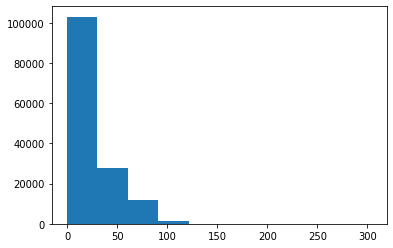

In [14]:
#data visualization library
import matplotlib.pyplot as plt
plt.hist(list(train_data_final['clean_comment_text'].str.split().map(lambda x: len(x))))

In [15]:
np.median(np.array(train_data_final['clean_comment_text'].str.split().map(lambda x: len(x))))

18.0

# Text Representation

## Loading the embedding matrix

In [16]:
embedding_dict = pd.read_pickle('../input/pickled-glove840b300d-for-10sec-loading/glove.840B.300d.pkl')

## Text Tokenization as Sequences

In [17]:
# Sequences creation, truncation and padding

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

# Setting up the tokenizer
vocab_size = 10000
tokenizer = Tokenizer(num_words = vocab_size, oov_token = 'UNK')
tokenizer.fit_on_texts(list(train_data_final['clean_comment_text']))

max_len = 18
X_train_seq = tokenizer.texts_to_sequences(train_data_final['clean_comment_text'])

X_train_seq = pad_sequences(X_train_seq, maxlen = max_len, truncating = 'post', padding = 'post')
#X_test_seq = pad_sequences(X_test_seq, maxlen = max_len, truncating = 'post', padding = 'post')


print(f"X_train shape: {X_train_seq.shape}")


X_train shape: (144334, 18)


In [18]:
y_train = np.array(train_data_final[possible_labels1]).astype(int)
print(f"y_train shape: {y_train.shape}")

y_train shape: (144334, 5)


## Train Validation Split

In [19]:
from sklearn.model_selection import train_test_split

X_train_seq, X_val_seq, y_train, y_val = train_test_split(X_train_seq, y_train, test_size = 0.2, random_state = 42)

print(f"X_train shape: {X_train_seq.shape}")
print(f"X_val shape: {X_val_seq.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_val shape: {y_val.shape}")

X_train shape: (115467, 18)
X_val shape: (28867, 18)
y_train shape: (115467, 5)
y_val shape: (28867, 5)


In [20]:
num_words = len(tokenizer.word_index)
print(f"Number of unique words: {num_words}")

Number of unique words: 135845


In [21]:
# Applying GloVE representations on our corpus

embedding_matrix=np.zeros((num_words,300))

for word,i in tokenizer.word_index.items():
    if i < num_words:
        emb_vec = embedding_dict.get(word)
        if emb_vec is not None:
            embedding_matrix[i] = emb_vec    
            
embedding_matrix.shape

(135845, 300)

# Modeling

## LSTM

In [22]:
# Setting up the model

from keras import layers
from keras.models import Sequential

def setup_lstm_model(max_len, n_latent_factors):
    
    model = Sequential()
    model.add(layers.Embedding(num_words, n_latent_factors, weights = [embedding_matrix], 
                               input_length = max_len, trainable = False))
    model.add(layers.LSTM(units = max_len, return_sequences = True))
    model.add(layers.GlobalAveragePooling1D())
    model.add(layers.Dense(units = 5, activation = 'sigmoid'))
    
    return model

In [23]:
lstm_model = setup_lstm_model(max_len = max_len, n_latent_factors = 300)
lstm_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 18, 300)           40753500  
_________________________________________________________________
lstm (LSTM)                  (None, 18, 18)            22968     
_________________________________________________________________
global_average_pooling1d (Gl (None, 18)                0         
_________________________________________________________________
dense (Dense)                (None, 5)                 95        
Total params: 40,776,563
Trainable params: 23,063
Non-trainable params: 40,753,500
_________________________________________________________________


In [24]:
# Final hyperparameter configurations
lstm_model.compile(optimizer = 'adam', loss = 'binary_crossentropy',metrics=['accuracy'])

batch_size = 128
epochs = 10

lstm_model.fit(X_train_seq, y_train, epochs=epochs, batch_size = batch_size, validation_data = (X_val_seq, y_val))

Epoch 1/10
903/903 [==============================] - 9s 6ms/step - loss: 0.2914 - accuracy: 0.7413 - val_loss: 0.1951 - val_accuracy: 0.7577
Epoch 2/10
903/903 [==============================] - 5s 6ms/step - loss: 0.1886 - accuracy: 0.7582 - val_loss: 0.1806 - val_accuracy: 0.7675
Epoch 3/10
903/903 [==============================] - 5s 6ms/step - loss: 0.1777 - accuracy: 0.7680 - val_loss: 0.1750 - val_accuracy: 0.7719
Epoch 4/10
903/903 [==============================] - 5s 6ms/step - loss: 0.1712 - accuracy: 0.7757 - val_loss: 0.1731 - val_accuracy: 0.7768
Epoch 5/10
903/903 [==============================] - 5s 5ms/step - loss: 0.1685 - accuracy: 0.7741 - val_loss: 0.1710 - val_accuracy: 0.7788
Epoch 6/10
903/903 [==============================] - 5s 6ms/step - loss: 0.1641 - accuracy: 0.7793 - val_loss: 0.1708 - val_accuracy: 0.7746
Epoch 7/10
903/903 [==============================] - 5s 6ms/step - loss: 0.1647 - accuracy: 0.7778 - val_loss: 0.1692 - val_accuracy: 0.7778
Epoch 

In [25]:
lstm_model.history.history

{'loss': [0.2334926426410675,
  0.18591609597206116,
  0.1763233244419098,
  0.1711207777261734,
  0.16792897880077362,
  0.16552188992500305,
  0.16365863382816315,
  0.16187366843223572,
  0.16035190224647522,
  0.15912434458732605],
 'accuracy': [0.7527951598167419,
  0.760944664478302,
  0.7688690423965454,
  0.7742211818695068,
  0.7753557562828064,
  0.7767153978347778,
  0.777624785900116,
  0.7783089280128479,
  0.779287576675415,
  0.779642641544342],
 'val_loss': [0.19510747492313385,
  0.18056510388851166,
  0.17504994571208954,
  0.17313523590564728,
  0.1710079163312912,
  0.17080220580101013,
  0.16923269629478455,
  0.16901905834674835,
  0.16861426830291748,
  0.16840717196464539],
 'val_accuracy': [0.7577164173126221,
  0.7674853801727295,
  0.7718502283096313,
  0.7768039703369141,
  0.7788131833076477,
  0.7746215462684631,
  0.7778085470199585,
  0.7774274945259094,
  0.7807184457778931,
  0.7805452346801758]}

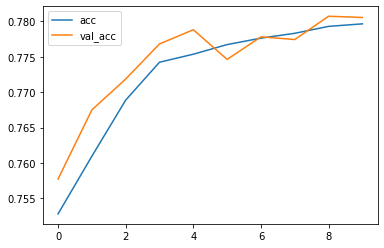

Training Accuracy is  : 0.779642641544342
Validation Accuracy is: 0.7807184457778931


In [26]:
# accuracies
plt.plot(lstm_model.history.history['accuracy'], label='acc')
plt.plot(lstm_model.history.history['val_accuracy'], label='val_acc')
plt.legend()
plt.show()

print("Training Accuracy is  :",max(lstm_model.history.history['accuracy']))
print("Validation Accuracy is:",max(lstm_model.history.history['val_accuracy']))

In [27]:
#from sklearn import metrics
#predictions = lstm_model.predict(X_val_seq)
#print(metrics.classification_report(y_val,predictions))

## GRU

In [28]:
def setup_gru_model(max_len, n_latent_factors):
    
    model = Sequential()
    model.add(layers.Embedding(num_words, n_latent_factors, weights = [embedding_matrix], 
                               input_length = max_len, trainable = False))
    model.add(layers.GRU(units = max_len, return_sequences = True))
    model.add(layers.GlobalAveragePooling1D())
    model.add(layers.Dense(units = 5, activation = 'sigmoid'))
    
    return model

In [29]:
gru_model = setup_gru_model(max_len = max_len, n_latent_factors = 300)
gru_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 18, 300)           40753500  
_________________________________________________________________
gru (GRU)                    (None, 18, 18)            17280     
_________________________________________________________________
global_average_pooling1d_1 ( (None, 18)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 95        
Total params: 40,770,875
Trainable params: 17,375
Non-trainable params: 40,753,500
_________________________________________________________________


In [30]:
# Final hyperparameter configurations and fitting
gru_model.compile(optimizer = 'adam', loss = 'binary_crossentropy',metrics=['accuracy'])

batch_size = 128
epochs = 10

gru_model.fit(X_train_seq, y_train, epochs=epochs, batch_size = batch_size, validation_data = (X_val_seq, y_val))

Epoch 1/10
903/903 [==============================] - 6s 6ms/step - loss: 0.3122 - accuracy: 0.7328 - val_loss: 0.1966 - val_accuracy: 0.7615
Epoch 2/10
903/903 [==============================] - 5s 6ms/step - loss: 0.1898 - accuracy: 0.7603 - val_loss: 0.1792 - val_accuracy: 0.7691
Epoch 3/10
903/903 [==============================] - 5s 5ms/step - loss: 0.1752 - accuracy: 0.7688 - val_loss: 0.1747 - val_accuracy: 0.7752
Epoch 4/10
903/903 [==============================] - 5s 6ms/step - loss: 0.1706 - accuracy: 0.7739 - val_loss: 0.1731 - val_accuracy: 0.7786
Epoch 5/10
903/903 [==============================] - 5s 6ms/step - loss: 0.1681 - accuracy: 0.7756 - val_loss: 0.1708 - val_accuracy: 0.7787
Epoch 6/10
903/903 [==============================] - 5s 6ms/step - loss: 0.1635 - accuracy: 0.7782 - val_loss: 0.1685 - val_accuracy: 0.7790
Epoch 7/10
903/903 [==============================] - 5s 5ms/step - loss: 0.1625 - accuracy: 0.7798 - val_loss: 0.1683 - val_accuracy: 0.7827
Epoch 

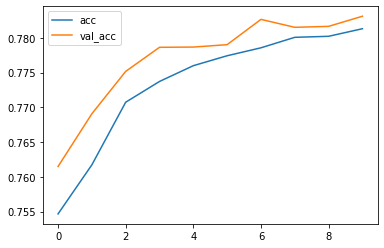

Training Accuracy is  : 0.7813141345977783
Validation Accuracy is: 0.7831087112426758


In [31]:
# accuracies
plt.plot(gru_model.history.history['accuracy'], label='acc')
plt.plot(gru_model.history.history['val_accuracy'], label='val_acc')
plt.legend()
plt.show()

print("Training Accuracy is  :",max(gru_model.history.history['accuracy']))
print("Validation Accuracy is:",max(gru_model.history.history['val_accuracy']))